# Multi-Sensor Deforestation Detection - Starter Notebook

See the full assignment at `https://docs.google.com/document/d/1VarFtPhMXp1etjYs1diNd93QdetRDdZIbRluz3EyDus/edit?usp=sharing`

## Getting Started

> Get the dataset by downloading this file: `https://storage.googleapis.com/capacity_shared/amazon_deforestation_v0.1/download_dataset.sh`

> and put it in a folder. Then:

```
  ./download_dataset.sh all --extract                    # Download and extract everything
  ./download_dataset.sh sentinel2 --extract              # Get only Sentinel-2 data
  ./download_dataset.sh essential                        # Minimum dataset for ML research
  ./download_dataset.sh metadata                         # Just get documentation first
```

This notebook provides a basic Sentinel-2 data loader for the multi-sensor deforestation detection challenge. See the full assignment document for complete requirements and evaluation criteria.

Important: This is Only 20% of the Solution

## What this notebook provides:

- Sentinel-2 optical data loading (RGBN bands)
- Basic preprocessing and visualization
- Dataset structure demonstration

## What you will need to add:

- Sentinel-1 SAR data (cloud-penetrating radar) - REQUIRED
- Temporal change detection (before/after comparison)
- Multi-sensor fusion architecture
- Robust data handling (clouds, missing files, quality issues)
- Performance evaluation vs single-sensor baselines

## Core Requirements Reminder

- Multi-sensor: Must use both SAR and optical data
- Change detection: Detect deforestation events over time
- Real-world robustness: Handle missing/corrupted data
- Measurable improvement: Beat single-sensor approaches

## 1. Import Libraries and Setup

Purpose: Import all necessary libraries for data loading, processing, and visualization

Note: You'll need additional libraries for SAR processing and multi-sensor fusion

In [7]:
# Core ML and data processing
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Geospatial data handling
import rasterio
from rasterio.windows import Window
import numpy as np

# File system and data structures
from pathlib import Path
import json
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

# Visualization and utilities
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)

print("✓ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")

✓ Libraries imported successfully
PyTorch version: 2.5.1+cu121


## 2. Define Data Structures

Purpose: Create dataclasses to represent satellite products and alert data
- some nice helper fucntions already to help keep the assignment within the time like product-specific normalization and band mapping

Extension needed: Add similar structures for Sentinel-1, Landsat, CBERS data

In [8]:
@dataclass
class Sentinel2Product:
    """
    Represents a single Sentinel-2 product with its file paths and metadata
    
    Attributes:
        tif_path: Path to the GeoTIFF file containing multi-band imagery
        bands_json_path: Path to JSON file describing band information
        metadata_path: Path to JSON file with acquisition metadata
        product_type: Data provider ('AWS', 'BDC_S2_L2A', 'BDC_S2-16D')
        date: Acquisition datetime
    """
    tif_path: Path
    bands_json_path: Path
    metadata_path: Path
    product_type: str  # 'AWS', 'BDC_S2_L2A', 'BDC_S2-16D'
    date: datetime
    
    def get_band_mapping(self) -> Dict[str, Optional[int]]:
        """
        Get band indices for RGBN based on product type
        
        Returns:
            Dictionary mapping color names to band indices
            
        Note: Both AWS and INPE BDC use Sentinel-2 band naming conventions:
        - B02 = Blue (490 nm)
        - B03 = Green (560 nm) 
        - B04 = Red (665 nm)
        - B08 = NIR (842 nm)
        """
        with open(self.bands_json_path, 'r') as f:
            bands_info = json.load(f)
        
        bands = bands_info['bands']
        
        # Both AWS and BDC use Sentinel-2 band nomenclature
        mapping = {
            'red': bands.index('B04') if 'B04' in bands else None,
            'green': bands.index('B03') if 'B03' in bands else None,
            'blue': bands.index('B02') if 'B02' in bands else None,
            'nir': bands.index('B08') if 'B08' in bands else None
        }
        
        # Validate mapping
        missing_bands = [color for color, idx in mapping.items() if idx is None]
        if missing_bands:
            print(f"⚠️  Missing bands {missing_bands} in {self.product_type} product")
            print(f"Available bands: {bands}")
        
        return mapping

@dataclass
class AlertData:
    """
    Represents all data for one deforestation alert
    
    Attributes:
        alert_id: Unique identifier from MapBiomas
        mask_path: Path to ground truth deforestation mask
        products: List of all satellite products for this alert
    """
    alert_id: str
    mask_path: Path
    products: List[Sentinel2Product]

print("✓ Data structures defined")

✓ Data structures defined


## 3. Implement Dataset Class

Purpose: Create PyTorch Dataset for loading and preprocessing Sentinel-2 data

Critical extension needed: Modify to handle multiple sensor types and temporal sequences

In [9]:
class Sentinel2Dataset(Dataset):
    """
    Enhanced PyTorch Dataset for Sentinel-2 deforestation alert imagery
    
    Features:
    - Product-specific normalization (AWS vs INPE BDC)
    - Robust band mapping with fallbacks
    - Enhanced error handling
    - Statistical normalization per product type
    """
    
    def __init__(self, root_dir: str, crop_size: int = 448, normalize: bool = True, 
                 augment: bool = False, product_specific_norm: bool = True):
        """
        Initialize the dataset
        
        Args:
            root_dir: Path to alert_imagery directory
            crop_size: Size of square crop in pixels (default 448x448)
            normalize: Whether to normalize bands to 0-1 range
            augment: Whether to apply random augmentations during training
            product_specific_norm: If True, compute separate normalization stats per product type
        """
        self.root_dir = Path(root_dir)
        self.crop_size = crop_size
        self.normalize = normalize
        self.augment = augment
        self.product_specific_norm = product_specific_norm
        
        # Load alerts first
        self.alerts = self._load_alerts()
        
        # Compute normalization statistics if needed
        if self.normalize and self.product_specific_norm:
            print("Computing product-specific normalization statistics...")
            self.norm_stats = self._compute_product_normalization_stats()
        else:
            self.norm_stats = None
        
        # Create flat list of all products for easy PyTorch indexing
        self.samples = []
        for alert in self.alerts:
            for product in alert.products:
                self.samples.append((alert, product))

    def _compute_product_normalization_stats(self, sample_size: int = 50):
        """
        Compute normalization statistics for each product type
        
        Args:
            sample_size: Number of samples per product type to analyze
        """
        from collections import defaultdict
        import random
        
        # Group products by type
        products_by_type = defaultdict(list)
        for alert in self.alerts:
            for product in alert.products:
                products_by_type[product.product_type].append(product)
        
        norm_stats = {}
        
        for product_type, products in products_by_type.items():
            print(f"  Computing stats for {product_type} ({len(products)} products)...")
            
            # Sample products for efficiency
            sample_products = random.sample(products, min(sample_size, len(products)))
            
            band_values = {i: [] for i in range(4)}  # RGBN bands
            
            for product in sample_products:
                try:
                    with rasterio.open(product.tif_path) as src:
                        # Get band mapping
                        band_map = product.get_band_mapping()
                        
                        # Sample a small window for efficiency
                        window_size = 100
                        row = random.randint(0, max(0, src.height - window_size))
                        col = random.randint(0, max(0, src.width - window_size))
                        window = Window(col, row, 
                                      min(window_size, src.width - col),
                                      min(window_size, src.height - row))
                        
                        # Read RGBN bands
                        for color_idx, color in enumerate(['red', 'green', 'blue', 'nir']):
                            if band_map[color] is not None:
                                band_data = src.read(band_map[color] + 1, window=window)
                                # Remove no-data values
                                valid_data = band_data[band_data > 0]
                                if len(valid_data) > 100:  # Ensure sufficient data
                                    band_values[color_idx].extend(valid_data.flatten().tolist())
                
                except Exception as e:
                    print(f"    Warning: Error processing {product.tif_path}: {e}")
                    continue
            
            # Compute statistics for each band
            band_stats = {}
            band_names = ['Red', 'Green', 'Blue', 'NIR']
            
            for band_idx in range(4):
                if band_values[band_idx]:
                    values = np.array(band_values[band_idx])
                    
                    # Use percentiles for robust statistics (avoid outliers)
                    p1, p99 = np.percentile(values, [1, 99])
                    valid_values = values[(values >= p1) & (values <= p99)]
                    
                    band_stats[band_idx] = {
                        'mean': np.mean(valid_values),
                        'std': np.std(valid_values),
                        'min': np.min(valid_values),
                        'max': np.max(valid_values),
                        'p1': p1,
                        'p99': p99
                    }
                    
                    print(f"    {band_names[band_idx]}: range=[{p1:.0f}, {p99:.0f}], mean={np.mean(valid_values):.0f}")
                else:
                    # Fallback to generic stats
                    print(f"    {band_names[band_idx]}: No valid data found, using fallback")
                    band_stats[band_idx] = {
                        'mean': 3000, 'std': 2000, 'min': 0, 'max': 10000,
                        'p1': 0, 'p99': 8000
                    }
            
            norm_stats[product_type] = band_stats
        
        return norm_stats

    def _apply_product_specific_normalization(self, rgbn: np.ndarray, product_type: str) -> np.ndarray:
        """
        Apply product-specific normalization to RGBN data
        
        Args:
            rgbn: Raw RGBN data of shape (4, H, W)
            product_type: Product type string
            
        Returns:
            Normalized RGBN data in [0,1] range
        """
        if not self.norm_stats or product_type not in self.norm_stats:
            # Fallback to generic normalization
            if rgbn.max() > 255:
                return np.clip(rgbn.astype(np.float32) / 10000.0, 0, 1)
            else:
                return np.clip(rgbn.astype(np.float32) / 255.0, 0, 1)
        
        stats = self.norm_stats[product_type]
        normalized = rgbn.astype(np.float32).copy()
        
        for band_idx in range(4):
            band_stats = stats[band_idx]
            
            # Min-Max normalization using robust percentiles
            p1, p99 = band_stats['p1'], band_stats['p99']
            if p99 > p1:  # Avoid division by zero
                normalized[band_idx] = np.clip(
                    (normalized[band_idx] - p1) / (p99 - p1), 0, 1
                )
            else:
                # Fallback if percentiles are equal
                normalized[band_idx] = np.clip(normalized[band_idx] / 10000.0, 0, 1)
        
        return normalized
    
    def _load_alerts(self) -> List[AlertData]:
        """
        Scan directory structure and load all alerts with their Sentinel-2 products
        Enhanced with better error handling and product type detection
        """
        alerts = []
        
        for alert_dir in self.root_dir.iterdir():
            if not alert_dir.is_dir():
                continue
            
            # Find ground truth mask
            mask_files = list(alert_dir.glob("*_mask.tif"))
            if not mask_files:
                continue  # Skip silently to reduce noise
            mask_path = mask_files[0]
            
            # Find Sentinel-2 products
            s2_dir = alert_dir / "sentinel2"
            if not s2_dir.exists():
                continue  # Skip silently
            
            products = []
            for tif_file in s2_dir.glob("*.tif"):
                # IMPORTANT: Skip derived indices - only load raw multi-band imagery
                filename = tif_file.name.lower()
                if any(index in filename for index in ['_ndvi', '_gndvi', '_ndwi', '_ndre', '_cri']):
                    continue
                
                # Find corresponding metadata files
                base_name = tif_file.stem
                bands_json = tif_file.parent / f"{base_name}_bands.json"
                metadata_json = tif_file.parent / f"{base_name}_metadata.json"
                
                if bands_json.exists() and metadata_json.exists():
                    try:
                        # Verify this is multi-band imagery (not single-band index)
                        with open(bands_json, 'r') as f:
                            bands_info = json.load(f)
                        
                        # Skip if less than 4 bands (likely a derived index)
                        if len(bands_info.get('bands', [])) < 4:
                            continue
                        
                        # Load metadata and determine product type
                        with open(metadata_json, 'r') as f:
                            metadata = json.load(f)
                        
                        # Enhanced product type classification
                        if 'S2-16D' in base_name:
                            product_type = 'BDC_S2-16D'  # INPE 16-day mosaic
                        elif any(pattern in base_name for pattern in ['S2A_MSIL2A', 'S2B_MSIL2A', 'S2_L2A']):
                            product_type = 'BDC_S2_L2A'  # INPE Level-2A
                        else:
                            product_type = 'AWS'  # AWS/Element84 product
                        
                        product = Sentinel2Product(
                            tif_path=tif_file,
                            bands_json_path=bands_json,
                            metadata_path=metadata_json,
                            product_type=product_type,
                            date=datetime.fromisoformat(metadata['datetime']) if metadata.get('datetime') else datetime.now()
                        )
                        products.append(product)
                        
                    except (json.JSONDecodeError, KeyError, ValueError) as e:
                        # Skip problematic files silently
                        continue
            
            if products:
                # Sort products by date for temporal analysis
                alerts.append(AlertData(
                    alert_id=alert_dir.name,
                    mask_path=mask_path,
                    products=sorted(products, key=lambda x: x.date)
                ))
        
        return alerts
    
    def _get_random_crop_params(self, height: int, width: int) -> Tuple[int, int]:
        """Get parameters for random crop during training"""
        if height >= self.crop_size and width >= self.crop_size:
            y = np.random.randint(0, height - self.crop_size + 1)
            x = np.random.randint(0, width - self.crop_size + 1)
        else:
            # Center crop if image is smaller than crop size
            y = max(0, (height - self.crop_size) // 2)
            x = max(0, (width - self.crop_size) // 2)
        return x, y
    
    def _center_crop_params(self, height: int, width: int) -> Tuple[int, int]:
        """Get parameters for center crop during inference"""
        y = max(0, (height - self.crop_size) // 2)
        x = max(0, (width - self.crop_size) // 2)
        return x, y
    
    def _apply_crop_and_pad(self, data: np.ndarray, x: int, y: int) -> np.ndarray:
        """Apply crop and pad to ensure consistent output size"""
        h, w = data.shape[-2:]
        
        # Crop to requested region
        y_end = min(y + self.crop_size, h)
        x_end = min(x + self.crop_size, w)
        
        if len(data.shape) == 3:  # Multi-band image
            cropped = data[:, y:y_end, x:x_end]
        else:  # Single band (mask)
            cropped = data[y:y_end, x:x_end]
        
        # Pad if necessary to reach crop_size
        if cropped.shape[-2] < self.crop_size or cropped.shape[-1] < self.crop_size:
            if len(data.shape) == 3:
                pad_h = self.crop_size - cropped.shape[1]
                pad_w = self.crop_size - cropped.shape[2]
                padded = np.pad(cropped, ((0, 0), (0, pad_h), (0, pad_w)), mode='constant')
            else:
                pad_h = self.crop_size - cropped.shape[0]
                pad_w = self.crop_size - cropped.shape[1]
                padded = np.pad(cropped, ((0, pad_h), (0, pad_w)), mode='constant')
            return padded
        
        return cropped
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Dict:
        """
        Load and preprocess a single sample with product-specific normalization
        """
        alert, product = self.samples[idx]
        
        # Load RGBN bands from satellite imagery
        with rasterio.open(product.tif_path) as src:
            height, width = src.height, src.width
            
            # Determine crop location
            if self.augment and hasattr(self, 'training') and self.training:
                x, y = self._get_random_crop_params(height, width)
            else:
                x, y = self._center_crop_params(height, width)
            
            # Define reading window for efficiency
            window = Window(x, y, 
                          min(self.crop_size, width - x), 
                          min(self.crop_size, height - y))
            
            # Get band mapping for this product type
            band_map = product.get_band_mapping()
            
            # Read RGBN bands
            rgbn_bands = []
            for color in ['red', 'green', 'blue', 'nir']:
                if band_map[color] is not None:
                    # Note: rasterio uses 1-based band indexing
                    band_data = src.read(band_map[color] + 1, window=window)
                    rgbn_bands.append(band_data)
                else:
                    # Handle missing bands by creating zeros
                    h = min(self.crop_size, height - y)
                    w = min(self.crop_size, width - x)
                    rgbn_bands.append(np.zeros((h, w), dtype=src.dtypes[0]))
            
            rgbn = np.stack(rgbn_bands, axis=0)  # Shape: (4, H, W)
            
            # Apply product-specific normalization
            if self.normalize:
                if self.product_specific_norm:
                    rgbn = self._apply_product_specific_normalization(rgbn, product.product_type)
                else:
                    # Generic normalization (original method)
                    if src.dtypes[0] == 'uint16' or rgbn.max() > 255:
                        rgbn = rgbn.astype(np.float32) / 10000.0
                    elif src.dtypes[0] == 'uint8':
                        rgbn = rgbn.astype(np.float32) / 255.0
                    else:
                        rgbn = rgbn.astype(np.float32)
                    rgbn = np.clip(rgbn, 0, 1)
            else:
                rgbn = rgbn.astype(np.float32)
        
        # Load corresponding ground truth mask
        with rasterio.open(alert.mask_path) as src:
            mask_height, mask_width = src.height, src.width
            
            # Calculate corresponding window for mask (may be different resolution)
            scale_x = mask_width / width
            scale_y = mask_height / height
            
            mask_x = int(x * scale_x)
            mask_y = int(y * scale_y)
            mask_window_w = int(self.crop_size * scale_x)
            mask_window_h = int(self.crop_size * scale_y)
            
            mask_window = Window(mask_x, mask_y,
                               min(mask_window_w, mask_width - mask_x),
                               min(mask_window_h, mask_height - mask_y))
            
            mask = src.read(1, window=mask_window)
        
        # Apply consistent cropping and padding
        rgbn = self._apply_crop_and_pad(rgbn, 0, 0)  # Already windowed
        
        # Resize mask to match imagery if needed
        if mask.shape != (self.crop_size, self.crop_size):
            import cv2
            mask = cv2.resize(mask, (self.crop_size, self.crop_size), 
                            interpolation=cv2.INTER_NEAREST)
        
        # Convert to PyTorch tensors
        rgbn_tensor = torch.from_numpy(rgbn).float()
        mask_tensor = torch.from_numpy(mask).long()
        
        # Apply data augmentation if enabled
        if self.augment and hasattr(self, 'training') and self.training:
            # Random horizontal flip
            if np.random.rand() > 0.5:
                rgbn_tensor = torch.flip(rgbn_tensor, dims=[2])
                mask_tensor = torch.flip(mask_tensor, dims=[1])
            
            # Random vertical flip
            if np.random.rand() > 0.5:
                rgbn_tensor = torch.flip(rgbn_tensor, dims=[1])
                mask_tensor = torch.flip(mask_tensor, dims=[0])
        
        return {
            'rgbn': rgbn_tensor,
            'mask': mask_tensor,
            'alert_id': alert.alert_id,
            'product_type': product.product_type,
            'date': product.date.isoformat()
        }
    
    def train(self):
        """Set dataset to training mode (enables augmentation)"""
        self.training = True
        return self
    
    def eval(self):
        """Set dataset to evaluation mode (disables augmentation)"""
        self.training = False
        return self

print("✓ Dataset class implemented with product-specific normalization")

✓ Dataset class implemented with product-specific normalization


## 4. Initialize Dataset and DataLoader

Purpose: Create dataset instance and examine what data is available

Key metric: Should find ~100 alerts with multiple products each

In [ ]:
# Initialize dataset
root_dir = "dataset"  # Update this path as needed
crop_size = 448  # Standard input size for many vision models

# Create dataset with 448x448 crops, normalization, no augmentation for exploration
dataset = Sentinel2Dataset(
    root_dir=root_dir, 
    crop_size=crop_size, 
    normalize=True, 
    augment=False
)

print(f"Dataset loaded successfully!")
print(f"Found {len(dataset)} Sentinel-2 products across {len(dataset.alerts)} alerts")
print(f"Average products per alert: {len(dataset) / len(dataset.alerts):.1f}")

# Analyze product types
product_types = {}
for alert in dataset.alerts:
    for product in alert.products:
        product_types[product.product_type] = product_types.get(product.product_type, 0) + 1

print(f"\nProduct type distribution:")
for ptype, count in product_types.items():
    print(f"  {ptype}: {count} products")

# Create DataLoader for batch processing
batch_size = 4  # Adjust based on your GPU memory
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0  # Set to 0 for debugging, increase for faster loading
)

print(f"DataLoader created with batch size {batch_size}")

Computing product-specific normalization statistics...
Dataset loaded successfully!
Found 0 Sentinel-2 products across 0 alerts


ZeroDivisionError: division by zero

## 5. Visualization Functions

Purpose: Create utilities to visualize satellite imagery and ground truth masks

Usage: Essential for debugging data loading and understanding the problem

In [79]:
def plot_batch(batch, figsize=(15, 12)):
    """
    Visualize a batch of RGBN images with their corresponding masks
    
    Args:
        batch: Dictionary from DataLoader containing 'rgbn', 'mask', etc.
        figsize: Figure size for matplotlib
    """
    rgbn = batch['rgbn']
    masks = batch['mask']
    alert_ids = batch['alert_id']
    product_types = batch['product_type']
    dates = batch['date']
    
    batch_size = rgbn.shape[0]
    fig, axes = plt.subplots(batch_size, 3, figsize=figsize)
    
    # Handle single sample case
    if batch_size == 1:
        axes = axes[np.newaxis, :]
    
    for i in range(batch_size):
        # Extract RGB bands (0=Red, 1=Green, 2=Blue in our RGBN ordering)
        rgb = rgbn[i, :3].permute(1, 2, 0).numpy()
        
        # Enhance visualization (satellite imagery is often dark)
        rgb_enhanced = np.clip(rgb * 2.5, 0, 1)  # Simple brightness enhancement
        
        # Extract NIR band (band 3)
        nir = rgbn[i, 3].numpy()
        
        # Extract mask
        mask = masks[i].numpy()
        
        # Plot RGB composite
        axes[i, 0].imshow(rgb_enhanced)
        axes[i, 0].set_title(f"Alert {alert_ids[i]} - RGB | {product_types[i]} | {dates[i][:10]}")
        axes[i, 0].axis('off')
        
        # Plot NIR band (vegetation appears bright in NIR)
        im_nir = axes[i, 1].imshow(nir, cmap='RdYlGn', vmin=0, vmax=1)
        axes[i, 1].set_title("NIR Band")
        axes[i, 1].axis('off')
        
        # Plot ground truth mask
        # Mask values: 0=forest, 1=deforestation, 255=nodata
        mask_display = np.where(mask == 255, np.nan, mask)  # Hide nodata as transparent
        im_mask = axes[i, 2].imshow(mask_display, cmap='RdBu_r', vmin=0, vmax=1)
        axes[i, 2].set_title("Deforestation Mask")
        axes[i, 2].axis('off')
        
        # Add colorbar for mask
        plt.colorbar(im_mask, ax=axes[i, 2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

def analyze_sample_statistics(dataset, num_samples=50):
    """
    Analyze statistics of the loaded data for debugging and understanding
    
    Args:
        dataset: Sentinel2Dataset instance
        num_samples: Number of samples to analyze
    """
    print(f"Analyzing statistics from {num_samples} samples...")
    
    rgbn_values = []
    mask_values = []
    
    for i in range(min(num_samples, len(dataset))):
        sample = dataset[i]
        rgbn_values.append(sample['rgbn'].numpy())
        mask_values.append(sample['mask'].numpy())
    
    rgbn_stack = np.stack(rgbn_values)
    mask_stack = np.stack(mask_values)
    
    print(f"\\nRGBN Statistics:")
    print(f"  Shape: {rgbn_stack.shape}")
    print(f"  Min/Max: {rgbn_stack.min():.4f} / {rgbn_stack.max():.4f}")
    print(f"  Mean: {rgbn_stack.mean():.4f}")
    print(f"  Std: {rgbn_stack.std():.4f}")
    
    print(f"\\nMask Statistics:")
    unique_vals, counts = np.unique(mask_stack, return_counts=True)
    total_pixels = mask_stack.size
    print(f"  Shape: {mask_stack.shape}")
    print(f"  Unique values and proportions:")
    for val, count in zip(unique_vals, counts):
        pct = 100 * count / total_pixels
        if val == 0:
            print(f"    {val} (Forest): {count:,} pixels ({pct:.1f}%)")
        elif val == 1:
            print(f"    {val} (Deforestation): {count:,} pixels ({pct:.1f}%)")
        elif val == 255:
            print(f"    {val} (NoData): {count:,} pixels ({pct:.1f}%)")
        else:
            print(f"    {val}: {count:,} pixels ({pct:.1f}%)")

print("✓ Visualization functions defined")

✓ Visualization functions defined


## 6: Load and Visualize Sample Data

Purpose: Load actual data and visualize it to verify everything works correctly

What to look for: RGB imagery, NIR response in vegetated areas, deforestation masks

Loading sample batch...
\nBatch Information:
  RGBN shape: torch.Size([4, 4, 448, 448])
  Mask shape: torch.Size([4, 448, 448])
  Product types: ['BDC_S2_L2A', 'BDC_S2_L2A', 'BDC_S2_L2A', 'AWS']
  Alert IDs: ['1388065', '1388028', '1389549', '1388022']
  Dates: ['2025-01-29', '2024-12-06', '2025-04-20', '2025-02-09']
\n==================================================
VISUALIZING SAMPLE BATCH


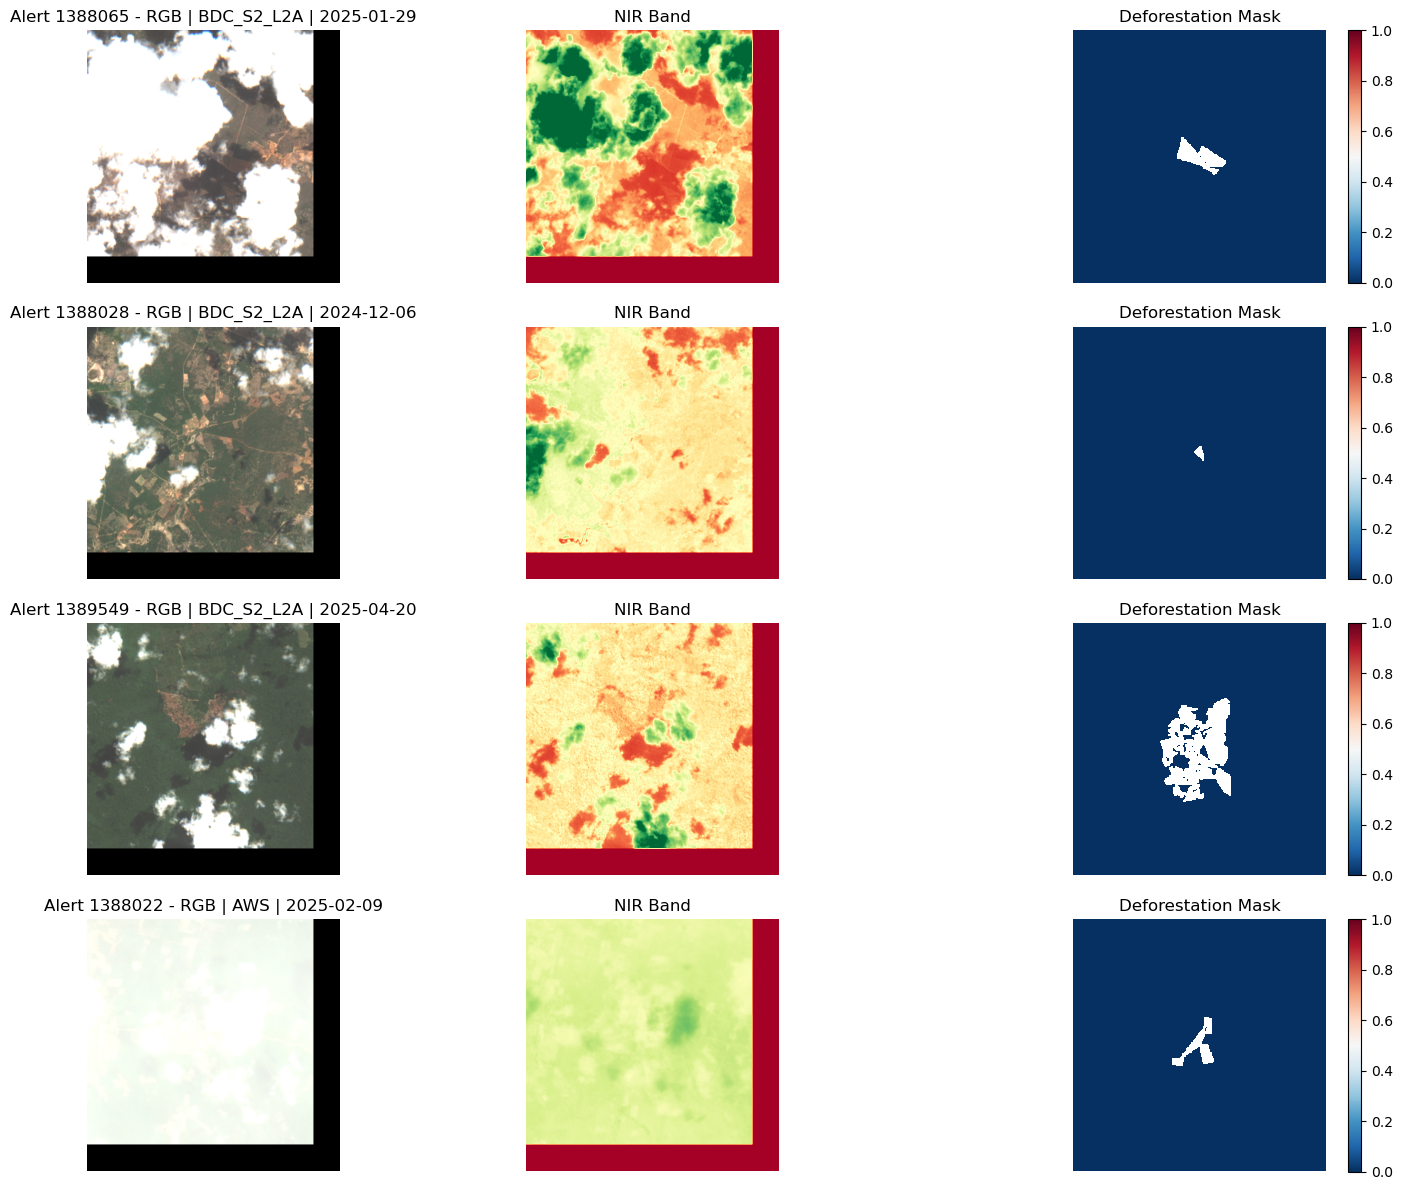

In [87]:
# Get one batch of data
print("Loading sample batch...")
batch = next(iter(dataloader))

# Display batch information
print("\\nBatch Information:")
print(f"  RGBN shape: {batch['rgbn'].shape}")  # Should be (batch_size, 4, 448, 448)
print(f"  Mask shape: {batch['mask'].shape}")  # Should be (batch_size, 448, 448)
print(f"  Product types: {batch['product_type']}")
print(f"  Alert IDs: {batch['alert_id']}")
print(f"  Dates: {[date[:10] for date in batch['date']]}")

print("\\n" + "="*50)
print("VISUALIZING SAMPLE BATCH")
print("="*50)

# Visualize the batch
plot_batch(batch)

## 7: Dataset Analysis and Statistics

Purpose: Analyze the loaded dataset to understand data characteristics

Key insights: Data distributions, temporal patterns, quality issues

EXPLORATORY DATA ANALYSIS - PRODUCT TYPE BAND ANALYSIS
Product types found: ['BDC_S2_L2A', 'BDC_S2-16D', 'AWS']
  BDC_S2_L2A: 185 samples
  BDC_S2-16D: 69 samples
  AWS: 46 samples


/tmp/ipykernel_43534/3437695602.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


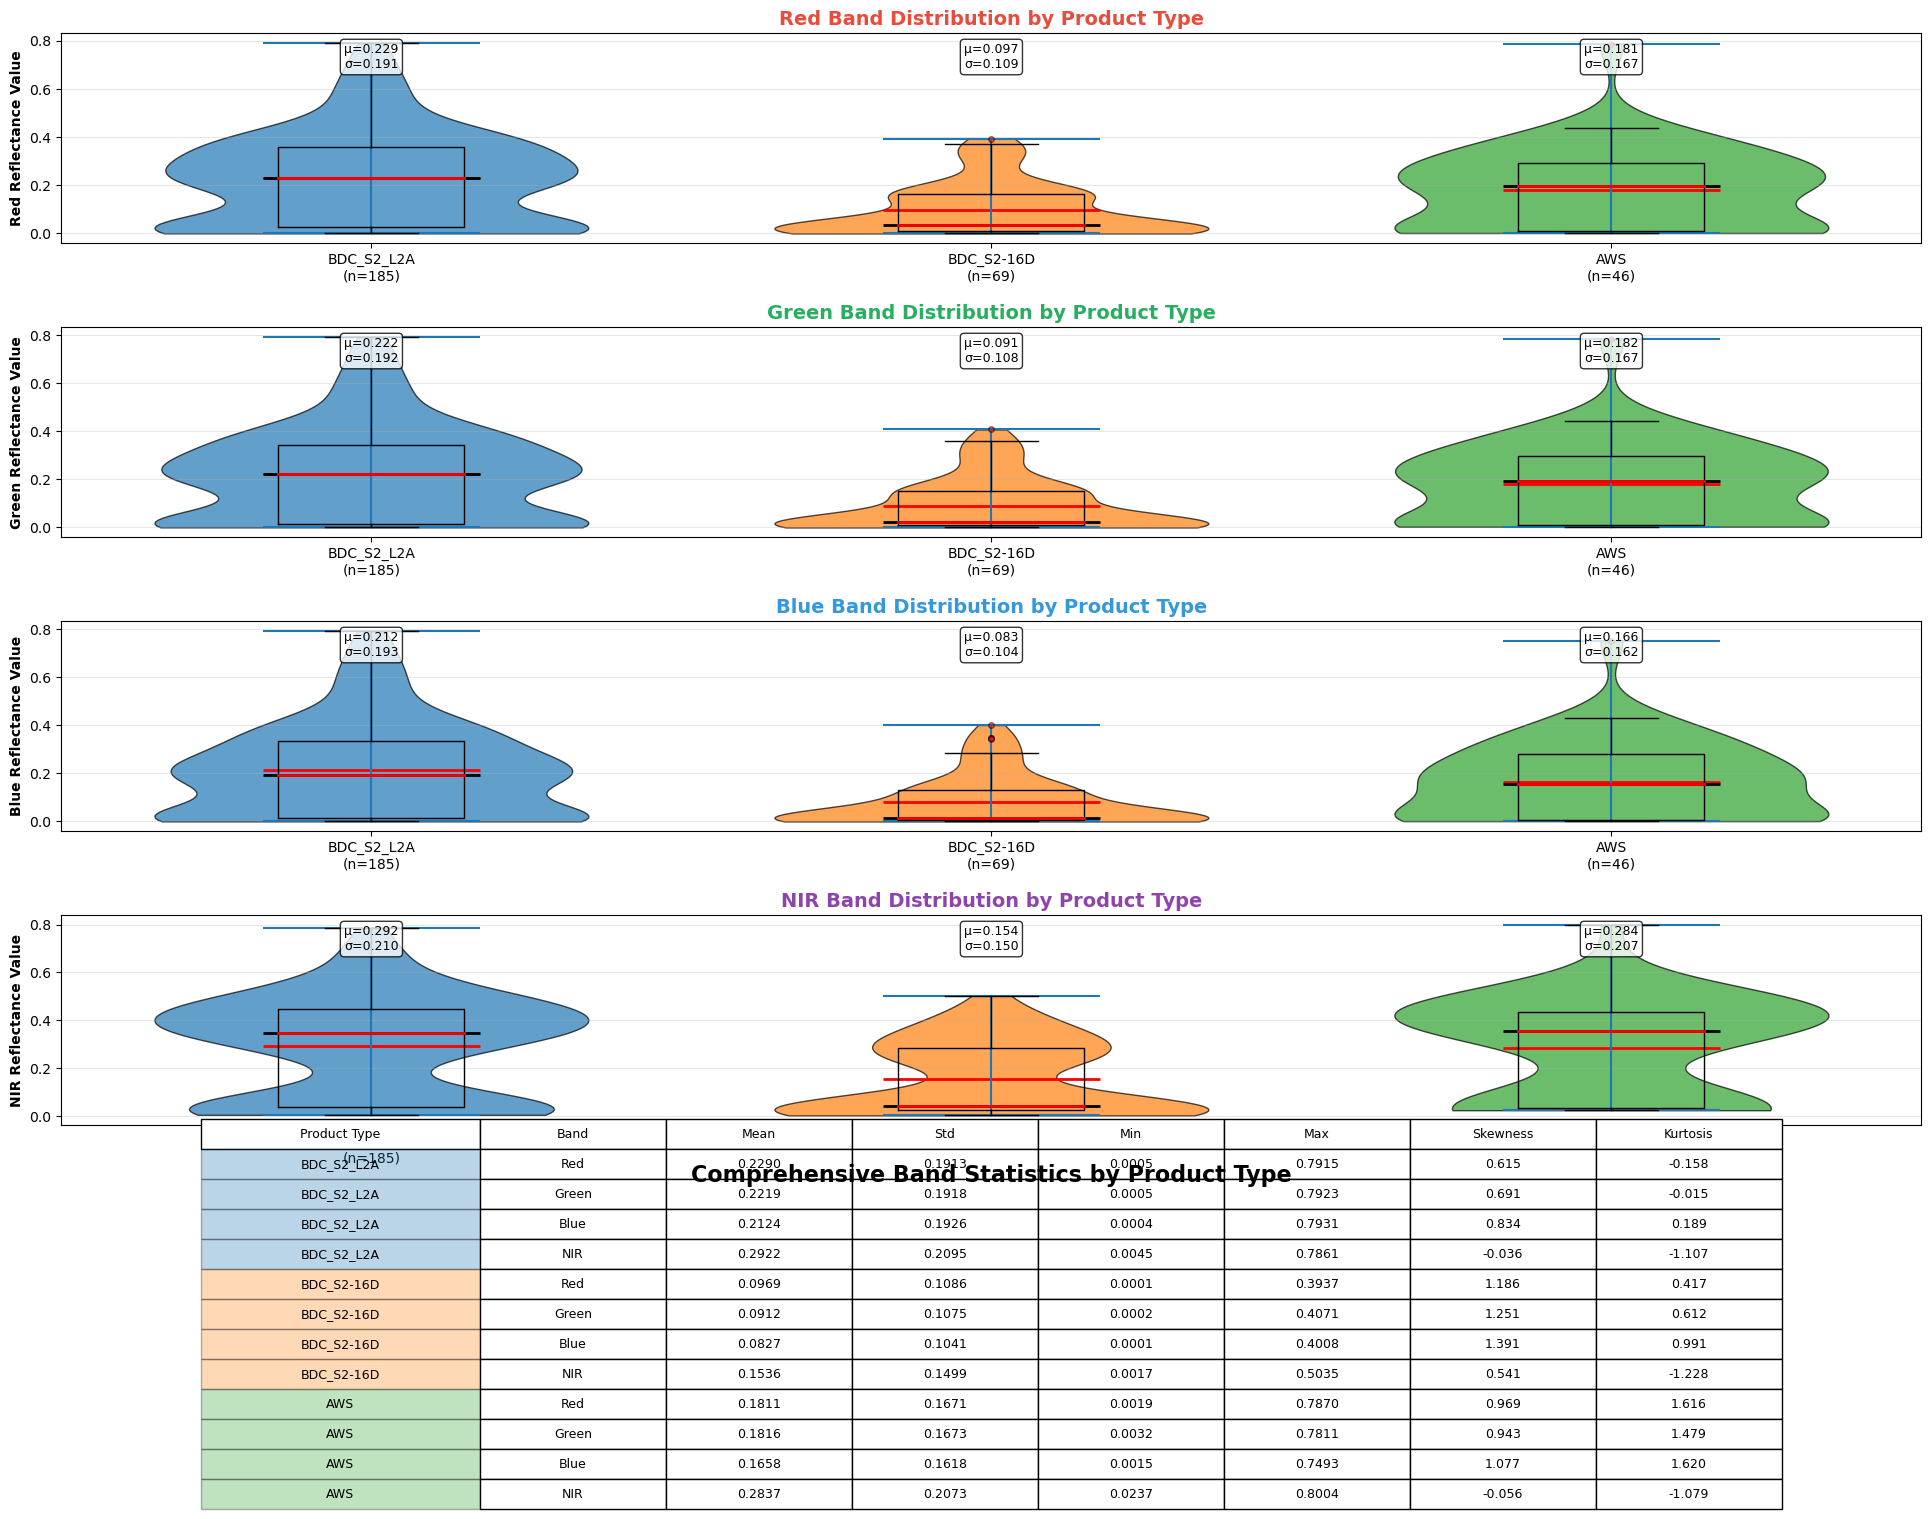


STATISTICAL SIGNIFICANCE ANALYSIS

🔍 RED BAND ANALYSIS:
  ANOVA F-test: F=14.776, p=0.0000
  Kruskal-Wallis: H=24.458, p=0.0000
  ✅ Significant differences detected between product types (ANOVA)
  ✅ Significant differences detected between product types (Kruskal-Wallis)
  Pairwise comparisons (t-test):
    BDC_S2_L2A vs BDC_S2-16D: p=0.0000 ***
    BDC_S2_L2A vs AWS: p=0.1225 ns
    BDC_S2-16D vs AWS: p=0.0015 **

🔍 GREEN BAND ANALYSIS:
  ANOVA F-test: F=14.366, p=0.0000
  Kruskal-Wallis: H=22.846, p=0.0000
  ✅ Significant differences detected between product types (ANOVA)
  ✅ Significant differences detected between product types (Kruskal-Wallis)
  Pairwise comparisons (t-test):
    BDC_S2_L2A vs BDC_S2-16D: p=0.0000 ***
    BDC_S2_L2A vs AWS: p=0.1948 ns
    BDC_S2-16D vs AWS: p=0.0007 ***

🔍 BLUE BAND ANALYSIS:
  ANOVA F-test: F=14.325, p=0.0000
  Kruskal-Wallis: H=24.005, p=0.0000
  ✅ Significant differences detected between product types (ANOVA)
  ✅ Significant differences detect

In [ ]:
print("EXPLORATORY DATA ANALYSIS - PRODUCT TYPE BAND ANALYSIS")
print("="*60)

# Collect larger sample for product-specific analysis
print("Collecting samples grouped by product type...")
sample_size = min(300, len(dataset))
indices = np.random.choice(len(dataset), sample_size, replace=False)

# Group samples by product type
product_groups = {}
for idx in indices:
    sample = dataset[idx]
    ptype = sample['product_type']
    
    if ptype not in product_groups:
        product_groups[ptype] = {
            'rgbn': [],
            'metadata': []
        }
    
    product_groups[ptype]['rgbn'].append(sample['rgbn'].numpy())
    product_groups[ptype]['metadata'].append({
        'alert_id': sample['alert_id'],
        'date': sample['date'][:10]
    })

# Convert to arrays for each product type
for ptype in product_groups:
    product_groups[ptype]['rgbn'] = np.stack(product_groups[ptype]['rgbn'])

print(f"Product types found: {list(product_groups.keys())}")
for ptype, data in product_groups.items():
    print(f"  {ptype}: {len(data['rgbn'])} samples")

# Create comprehensive band analysis by product type
fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(5, 4, hspace=0.4, wspace=0.3)

band_names = ['Red', 'Green', 'Blue', 'NIR']
band_colors = ['#e74c3c', '#27ae60', '#3498db', '#8e44ad']
product_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# 1. Individual Band Distributions by Product Type (Top 4 rows)
for band_idx, (band, band_color) in enumerate(zip(band_names, band_colors)):
    ax = fig.add_subplot(gs[band_idx, :])
    
    # Collect all product type data for this band
    all_data = []
    labels = []
    colors = []
    
    for i, (ptype, data) in enumerate(product_groups.items()):
        if len(data['rgbn']) > 5:  # Only include types with sufficient samples
            # Get band data (mean across spatial dimensions for each sample)
            band_means = data['rgbn'][:, band_idx, :, :].mean(axis=(1, 2))
            all_data.append(band_means)
            labels.append(f"{ptype}\n(n={len(band_means)})")
            colors.append(product_colors[i % len(product_colors)])
    
    if all_data:
        # Create violin plots for better distribution visualization
        parts = ax.violinplot(all_data, positions=range(len(all_data)), 
                             widths=0.7, showmeans=True, showmedians=True)
        
        # Color the violin plots
        for i, (pc, color) in enumerate(zip(parts['bodies'], colors)):
            pc.set_facecolor(color)
            pc.set_alpha(0.7)
            pc.set_edgecolor('black')
            pc.set_linewidth(1)
        
        # Customize other elements
        parts['cmeans'].set_color('red')
        parts['cmeans'].set_linewidth(2)
        parts['cmedians'].set_color('black')
        parts['cmedians'].set_linewidth(2)
        
        # Add box plots overlay for quartiles
        bp = ax.boxplot(all_data, positions=range(len(all_data)), 
                       widths=0.3, patch_artist=False,
                       boxprops=dict(color='black', linewidth=1),
                       whiskerprops=dict(color='black', linewidth=1),
                       capprops=dict(color='black', linewidth=1),
                       medianprops=dict(color='red', linewidth=2),
                       flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.5))
        
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=0, ha='center')
        ax.set_title(f'{band} Band Distribution by Product Type', 
                    fontweight='bold', fontsize=14, color=band_color)
        ax.set_ylabel(f'{band} Reflectance Value', fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add statistical annotations
        for i, data_array in enumerate(all_data):
            mean_val = np.mean(data_array)
            std_val = np.std(data_array)
            ax.text(i, ax.get_ylim()[1] * 0.95, f'μ={mean_val:.3f}\nσ={std_val:.3f}', 
                   ha='center', va='top', fontsize=9, 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# 5. Statistical Comparison Table (Bottom row)
ax_table = fig.add_subplot(gs[4, :])
ax_table.axis('tight')
ax_table.axis('off')

# Create comprehensive statistics table
table_data = []
headers = ['Product Type', 'Band', 'Mean', 'Std', 'Min', 'Max', 'Skewness', 'Kurtosis']

for ptype, data in product_groups.items():
    if len(data['rgbn']) > 5:
        for band_idx, band in enumerate(band_names):
            band_means = data['rgbn'][:, band_idx, :, :].mean(axis=(1, 2))
            
            from scipy import stats
            skewness = stats.skew(band_means)
            kurtosis = stats.kurtosis(band_means)
            
            table_data.append([
                ptype,
                band,
                f"{np.mean(band_means):.4f}",
                f"{np.std(band_means):.4f}",
                f"{np.min(band_means):.4f}",
                f"{np.max(band_means):.4f}",
                f"{skewness:.3f}",
                f"{kurtosis:.3f}"
            ])

# Create table
table = ax_table.table(cellText=table_data, colLabels=headers,
                      cellLoc='center', loc='center',
                      colWidths=[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.0, 1.8)

# Color-code table cells based on product type
product_type_colors = {ptype: product_colors[i % len(product_colors)] 
                      for i, ptype in enumerate(product_groups.keys())}

for i, row in enumerate(table_data):
    ptype = row[0]
    color = product_type_colors.get(ptype, '#ffffff')
    # Color the product type column
    table[(i + 1, 0)].set_facecolor(color)
    table[(i + 1, 0)].set_alpha(0.3)

ax_table.set_title('Comprehensive Band Statistics by Product Type', 
                  fontweight='bold', fontsize=16, pad=20)

plt.tight_layout()
plt.show()

# Statistical significance testing between product types
print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE ANALYSIS")
print("="*60)

from scipy.stats import f_oneway, kruskal
import itertools

# Perform ANOVA and Kruskal-Wallis tests for each band
for band_idx, band in enumerate(band_names):
    print(f"\n🔍 {band.upper()} BAND ANALYSIS:")
    
    # Collect data for each product type
    band_data_by_type = {}
    for ptype, data in product_groups.items():
        if len(data['rgbn']) > 5:
            band_means = data['rgbn'][:, band_idx, :, :].mean(axis=(1, 2))
            band_data_by_type[ptype] = band_means
    
    if len(band_data_by_type) >= 2:
        # ANOVA test (assumes normal distribution)
        data_arrays = list(band_data_by_type.values())
        f_stat, p_anova = f_oneway(*data_arrays)
        
        # Kruskal-Wallis test (non-parametric alternative)
        h_stat, p_kruskal = kruskal(*data_arrays)
        
        print(f"  ANOVA F-test: F={f_stat:.3f}, p={p_anova:.4f}")
        print(f"  Kruskal-Wallis: H={h_stat:.3f}, p={p_kruskal:.4f}")
        
        if p_anova < 0.05:
            print(f"  ✅ Significant differences detected between product types (ANOVA)")
        else:
            print(f"  ❌ No significant differences detected (ANOVA)")
            
        if p_kruskal < 0.05:
            print(f"  ✅ Significant differences detected between product types (Kruskal-Wallis)")
        else:
            print(f"  ❌ No significant differences detected (Kruskal-Wallis)")
        
        # Pairwise comparisons if significant
        if p_anova < 0.05 and len(band_data_by_type) > 2:
            print(f"  Pairwise comparisons (t-test):")
            from scipy.stats import ttest_ind
            
            type_names = list(band_data_by_type.keys())
            for i, j in itertools.combinations(range(len(type_names)), 2):
                type1, type2 = type_names[i], type_names[j]
                t_stat, p_val = ttest_ind(band_data_by_type[type1], band_data_by_type[type2])
                significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                print(f"    {type1} vs {type2}: p={p_val:.4f} {significance}")

# Summary insights
print("\n" + "="*60)
print("KEY INSIGHTS FOR MULTI-SENSOR FUSION")
print("="*60)

print("\n📈 PRODUCT TYPE DIFFERENCES:")
for band_idx, band in enumerate(band_names):
    means_by_type = {}
    for ptype, data in product_groups.items():
        if len(data['rgbn']) > 5:
            band_means = data['rgbn'][:, band_idx, :, :].mean(axis=(1, 2))
            means_by_type[ptype] = np.mean(band_means)
    
    if len(means_by_type) >= 2:
        max_type = max(means_by_type, key=means_by_type.get)
        min_type = min(means_by_type, key=means_by_type.get)
        diff_pct = 100 * (means_by_type[max_type] - means_by_type[min_type]) / means_by_type[min_type]
        
        print(f"  {band}: {max_type} shows {diff_pct:.1f}% higher values than {min_type}")

## 8. Data Quality Verification

Purpose: Verify data integrity and identify potential issues

Critical for: Ensuring robust model training and identifying data problems early

In [90]:
def verify_data_quality(dataset, num_checks=25):
    """
    Perform comprehensive data quality checks
    
    Args:
        dataset: Sentinel2Dataset instance
        num_checks: Number of samples to verify
    """
    print(f"Running data quality checks on {num_checks} samples...")
    
    issues = []
    
    for i in range(min(num_checks, len(dataset))):
        try:
            sample = dataset[i]
            
            # Check tensor shapes
            if sample['rgbn'].shape != (4, dataset.crop_size, dataset.crop_size):
                issues.append(f"Sample {i}: Wrong RGBN shape {sample['rgbn'].shape}")
            
            if sample['mask'].shape != (dataset.crop_size, dataset.crop_size):
                issues.append(f"Sample {i}: Wrong mask shape {sample['mask'].shape}")
            
            # Check for NaN values
            if torch.isnan(sample['rgbn']).any():
                issues.append(f"Sample {i}: NaN values in RGBN")
            
            if torch.isnan(sample['mask']).any():
                issues.append(f"Sample {i}: NaN values in mask")
            
            # Check value ranges
            rgbn_min, rgbn_max = sample['rgbn'].min(), sample['rgbn'].max()
            if rgbn_min < -1 or rgbn_max > 2:  # Allow some tolerance
                issues.append(f"Sample {i}: Unusual RGBN range [{rgbn_min:.3f}, {rgbn_max:.3f}]")
            
            # Check mask values
            mask_unique = torch.unique(sample['mask'])
            valid_mask_values = {0, 1, 255}  # forest, deforestation, nodata
            if not set(mask_unique.tolist()).issubset(valid_mask_values):
                issues.append(f"Sample {i}: Unexpected mask values {mask_unique.tolist()}")
                
        except Exception as e:
            issues.append(f"Sample {i}: Error loading sample - {str(e)}")
    
    if issues:
        print(f"\n⚠️  Found {len(issues)} issues:")
        for issue in issues[:10]:  # Show first 10 issues
            print(f"  {issue}")
        if len(issues) > 10:
            print(f"  ... and {len(issues) - 10} more issues")
    else:
        print("✓ All quality checks passed!")
    
    return len(issues) == 0

In [91]:
print("DATA QUALITY VERIFICATION")
print("="*50)

# Run comprehensive quality checks
quality_ok = verify_data_quality(dataset, num_checks=25)

# Display temporal distribution
print(f"TEMPORAL DISTRIBUTION ANALYSIS:")
print("-" * 30)
all_dates = []
for alert in dataset.alerts:
    for product in alert.products:
        all_dates.append(product.date)

if all_dates:
    earliest = min(all_dates)
    latest = max(all_dates)
    print(f"Date range: {earliest.strftime('%Y-%m-%d')} to {latest.strftime('%Y-%m-%d')}")
    print(f"Total time span: {(latest - earliest).days} days")
    
    # Group by month for temporal analysis
    from collections import defaultdict
    monthly_counts = defaultdict(int)
    for date in all_dates:
        month_key = date.strftime('%Y-%m')
        monthly_counts[month_key] += 1
    
    print(f"Products per month (last 6 months):")
    for month in sorted(monthly_counts.keys())[-6:]:
        print(f"  {month}: {monthly_counts[month]} products")

# Show alerts with most/least data for debugging
print(f"ALERT DATA COVERAGE:")
print("-" * 20)
alert_counts = [(alert.alert_id, len(alert.products)) for alert in dataset.alerts]
alert_counts.sort(key=lambda x: x[1], reverse=True)

print("Top 5 alerts by product count:")
for alert_id, count in alert_counts[:5]:
    print(f"  {alert_id}: {count} products")

print("Bottom 5 alerts by product count:")
for alert_id, count in alert_counts[-5:]:
    print(f"  {alert_id}: {count} products")

print()
if quality_ok:
    print(f"✅ Dataset ready for multi-sensor extension!")
else:
    print(f"⚠️  Found data quality issues - review warnings above")

DATA QUALITY VERIFICATION
Running data quality checks on 25 samples...
✓ All quality checks passed!
TEMPORAL DISTRIBUTION ANALYSIS:
------------------------------
Date range: 2024-10-31 to 2025-06-26
Total time span: 238 days
Products per month (last 6 months):
  2025-01: 204 products
  2025-02: 134 products
  2025-03: 96 products
  2025-04: 75 products
  2025-05: 97 products
  2025-06: 27 products
ALERT DATA COVERAGE:
--------------------
Top 5 alerts by product count:
  1388059: 30 products
  1389494: 27 products
  1388047: 26 products
  1387993: 24 products
  1387972: 23 products
Bottom 5 alerts by product count:
  1389489: 2 products
  1389728: 2 products
  1387941: 1 products
  1389158: 1 products
  1389384: 1 products

✅ Dataset ready for multi-sensor extension!


In [92]:
# batch information
print("Batch shapes:")
print(f"  RGBN: {batch['rgbn'].shape}")  # Should be (batch_size, 4, 448, 448)
print(f"  Mask: {batch['mask'].shape}")  # Should be (batch_size, 448, 448)
print(f"\nProduct types in batch: {batch['product_type']}")
print(f"Alert IDs: {batch['alert_id']}")

Batch shapes:
  RGBN: torch.Size([4, 4, 448, 448])
  Mask: torch.Size([4, 448, 448])

Product types in batch: ['BDC_S2_L2A', 'BDC_S2_L2A', 'BDC_S2_L2A', 'AWS']
Alert IDs: ['1388065', '1388028', '1389549', '1388022']


In [93]:
# erify all samples have the same size
print("\nVerifying all samples have consistent size...")
for i in range(min(10, len(dataset))):
    sample = dataset[i]
    assert sample['rgbn'].shape == (4, 448, 448), f"Sample {i} has wrong RGBN shape: {sample['rgbn'].shape}"
    assert sample['mask'].shape == (448, 448), f"Sample {i} has wrong mask shape: {sample['mask'].shape}"
print("✓ All samples have correct shape!")


Verifying all samples have consistent size...
✓ All samples have correct shape!


## Bonus: GEOGRAPHIC ANALYSIS: MAPBIOMAS ALERTS DISTRIBUTION ON A MAP

In [94]:
# Load and visualize MapBiomas alerts on map
try:
    import geopandas as gpd
    import folium
    from folium import plugins
    
    # Try to load the alerts GeoJSON file
    alerts_file = Path("mapbiomas_alerts.geojson")
    if alerts_file.exists():
        print(f"\nLoading MapBiomas alerts from: {alerts_file}")
        
        # Load alerts as GeoDataFrame
        alerts_gdf = gpd.read_file(alerts_file)
        
        print(f"Loaded {len(alerts_gdf)} MapBiomas alerts")
        print(f"Alert dataset covers {len(dataset.alerts)} of these alerts")
        
        # Display basic info about alerts
        if 'areaHa' in alerts_gdf.columns:
            print(f"\nAlert size statistics:")
            print(f"  Mean area: {alerts_gdf['areaHa'].mean():.1f} hectares")
            print(f"  Median area: {alerts_gdf['areaHa'].median():.1f} hectares")
            print(f"  Min area: {alerts_gdf['areaHa'].min():.1f} hectares")
            print(f"  Max area: {alerts_gdf['areaHa'].max():.1f} hectares")
        
        # Create interactive map
        print(f"\nCreating interactive map of alert locations...")
        
        # Calculate map center
        bounds = alerts_gdf.total_bounds  # [minx, miny, maxx, maxy]
        center_lat = (bounds[1] + bounds[3]) / 2
        center_lon = (bounds[0] + bounds[2]) / 2
        
        # Create base map
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=6,
            tiles='OpenStreetMap'
        )
        
        # Add alerts to map
        # Filter to only alerts that have imagery data
        alerts_with_data = alerts_gdf[alerts_gdf.index.isin([
            int(alert.alert_id) if alert.alert_id.isdigit() else None 
            for alert in dataset.alerts
        ])].dropna()
        
        if len(alerts_with_data) == 0:
            # Fallback: try matching by alert_code or other ID column
            id_columns = ['alert_code', 'alertCode', 'id', 'gid']
            for col in id_columns:
                if col in alerts_gdf.columns:
                    dataset_ids = {alert.alert_id for alert in dataset.alerts}
                    alerts_with_data = alerts_gdf[alerts_gdf[col].astype(str).isin(dataset_ids)]
                    if len(alerts_with_data) > 0:
                        print(f"Matched alerts using column: {col}")
                        break
        
        if len(alerts_with_data) > 0:
            print(f"Mapping {len(alerts_with_data)} alerts with satellite data")
            
            # Add alerts with different colors based on area
            for idx, alert in alerts_with_data.iterrows():
                # Determine popup text
                popup_text = f"Alert ID: {alert.get('alert_code', alert.get('alertCode', idx))}"
                if 'areaHa' in alert:
                    popup_text += f"<br>Area: {alert['areaHa']:.1f} ha"
                if 'detectedAt' in alert:
                    popup_text += f"<br>Detected: {alert['detectedAt']}"
                
                # Color based on area with explicit color definitions
                if 'areaHa' in alert:
                    area = alert['areaHa']
                    if area < 10:
                        marker_color = '#28a745'  # Green
                        fill_color = '#28a745'
                    elif area < 50:
                        marker_color = '#fd7e14'  # Orange
                        fill_color = '#fd7e14' 
                    else:
                        marker_color = '#dc3545'  # Red
                        fill_color = '#dc3545'
                else:
                    marker_color = '#007bff'  # Blue
                    fill_color = '#007bff'
                
                # Add marker with explicit colors
                folium.CircleMarker(
                    location=[alert.geometry.centroid.y, alert.geometry.centroid.x],
                    radius=6,
                    popup=folium.Popup(popup_text, max_width=300),
                    color=marker_color,
                    fillColor=fill_color,
                    fillOpacity=0.8,
                    weight=2,
                    opacity=1.0
                ).add_to(m)
            
            # Add improved legend with higher z-index and better positioning
            legend_html = '''
            <div style="position: fixed; 
                        top: 10px; right: 10px; width: 180px; height: 120px; 
                        background-color: white; border: 2px solid grey; z-index: 9999; 
                        font-size: 12px; padding: 10px; border-radius: 5px;
                        box-shadow: 0 0 15px rgba(0,0,0,0.2);">
            <p style="margin: 0 0 8px 0; font-weight: bold; font-size: 14px;">Alert Size (hectares)</p>
            <p style="margin: 4px 0;"><span style="display: inline-block; width: 12px; height: 12px; 
               background-color: #28a745; border-radius: 50%; margin-right: 8px;"></span>< 10 ha</p>
            <p style="margin: 4px 0;"><span style="display: inline-block; width: 12px; height: 12px; 
               background-color: #fd7e14; border-radius: 50%; margin-right: 8px;"></span>10-50 ha</p>
            <p style="margin: 4px 0;"><span style="display: inline-block; width: 12px; height: 12px; 
               background-color: #dc3545; border-radius: 50%; margin-right: 8px;"></span>> 50 ha</p>
            </div>
            '''
            m.get_root().html.add_child(folium.Element(legend_html))
            
            # Display map
            display(m)
            
        else:
            print("⚠️  Could not match alert IDs between GeoJSON and dataset")
            print("Available GeoJSON columns:", list(alerts_gdf.columns))
            print("Sample dataset alert IDs:", [alert.alert_id for alert in dataset.alerts[:5]])
            
            # Still show the geographic distribution using geopandas explore
            print("\nShowing all alerts with geopandas explore...")
            display(alerts_gdf.explore(
                column='areaHa' if 'areaHa' in alerts_gdf.columns else None,
                cmap='Reds',
                legend=True,
                figsize=(12, 8),
                tiles='OpenStreetMap'
            ))
        
    else:
        print(f"⚠️  MapBiomas alerts file not found at expected locations:")
        print(f"  - {Path(root_dir).parent / 'alerts' / 'mapbiomas_alerts_sample.geojson'}")
        print(f"  - alerts/mapbiomas_alerts_sample.geojson")
        print("\nContinuing without geographic visualization...")

except ImportError as e:
    print(f"⚠️  Geographic visualization requires additional packages:")
    print(f"  pip install geopandas folium")
    print(f"  Error: {e}")
    print("\nContinuing without map visualization...")

except Exception as e:
    print(f"⚠️  Error loading geographic data: {e}")
    print("Continuing without map visualization...")


Loading MapBiomas alerts from: mapbiomas_alerts.geojson
Loaded 100 MapBiomas alerts
Alert dataset covers 77 of these alerts

Alert size statistics:
  Mean area: 11.2 hectares
  Median area: 3.7 hectares
  Min area: 0.8 hectares
  Max area: 129.5 hectares

Creating interactive map of alert locations...
Matched alerts using column: alertCode
Mapping 77 alerts with satellite data


/tmp/ipykernel_43534/2564557845.py:46: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  ])].dropna()


In [95]:
alerts_gdf

,alertCode,detectedAt,publishedAt,areaHa,boundingBox,geometry
0,1390023,2025-05-27,2025-07-15,6.3755,"{ ""neLat"": -49.871251985105211, ""neLng"": -3.95...","POLYGON ((-49.87957 -3.96593, -49.88108 -3.964..."
1,1389968,2025-05-15,2025-07-15,38.5156,"{ ""neLat"": -56.153805190999989, ""neLng"": -9.53...","POLYGON ((-56.15915 -9.54676, -56.15959 -9.547..."
2,1389891,2025-05-09,2025-07-15,15.9034,"{ ""neLat"": -55.801106900500002, ""neLng"": -9.30...","POLYGON ((-55.80481 -9.31849, -55.8052 -9.3187..."
3,1389833,2025-05-01,2025-07-15,33.7284,"{ ""neLat"": -49.849707005000006, ""neLng"": -3.80...","POLYGON ((-49.85284 -3.81133, -49.85344 -3.812..."
4,1389786,2025-05-21,2025-07-15,7.5356,"{ ""neLat"": -59.375181766000011, ""neLng"": -9.21...","POLYGON ((-59.37777 -9.2188, -59.37758 -9.2191..."
...,...,...,...,...,...,...
95,1387928,2025-02-01,2025-07-01,1.7526,"{ ""neLat"": -43.01527848510522, ""neLng"": -9.624...","POLYGON ((-43.0245 -9.63292, -43.02339 -9.6326..."
96,1387927,2025-01-01,2025-07-01,6.8860,"{ ""neLat"": -44.162712985105216, ""neLng"": -9.97...","POLYGON ((-44.16928 -9.98113, -44.173 -9.98018..."
97,1387926,2025-01-01,2025-07-09,2.7485,"{ ""neLat"": -37.365970985105214, ""neLng"": -5.70...","POLYGON ((-37.3748 -5.71364, -37.37519 -5.7135..."
98,1387925,2025-02-01,2025-07-09,1.1206,"{ ""neLat"": -37.892132985105214, ""neLng"": -6.99...","POLYGON ((-37.90149 -7.00568, -37.90009 -7.005..."
